<a href="https://www.kaggle.com/code/gungunfite/notebook1a706d923c?scriptVersionId=151150587" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:

# Load the data
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')



In [3]:
# Displaying the basic information about the dataset
print(df.head())
print(df.info())
print(df.describe())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
                 id      target
coun

In [4]:
# importing dependencies
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


# Data pre-processing 

In [5]:
# Remove NaN values
df = df.fillna('')

# Text cleaning
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower()  
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

In [6]:
# Tokenization and removing stop words
stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['cleaned_text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['cleaned_text']).toarray()

# Model Building 

In [7]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, df['target'], test_size=0.2, random_state=42)





In [8]:

# Ensemble Model
classifiers = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Machine', SVC())
]

# Create a Voting Classifier (Hard Voting)
ensemble_model = VotingClassifier(estimators=classifiers, voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Validation set for Ensemble Model
y_pred_val_ensemble = ensemble_model.predict(X_val)



In [9]:
# Evaluate the SVM model on the validation set
accuracy_val_ensemble = accuracy_score(y_val, y_pred_val_ensemble)
print(f'SVM - Validation Accuracy: {accuracy_val_ensemble:.2f}')


SVM - Validation Accuracy: 0.81


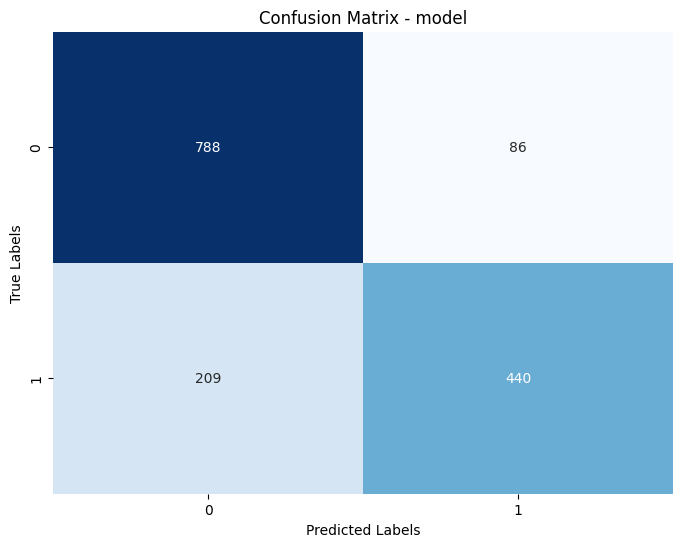

Classification Report - model:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.84      0.68      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



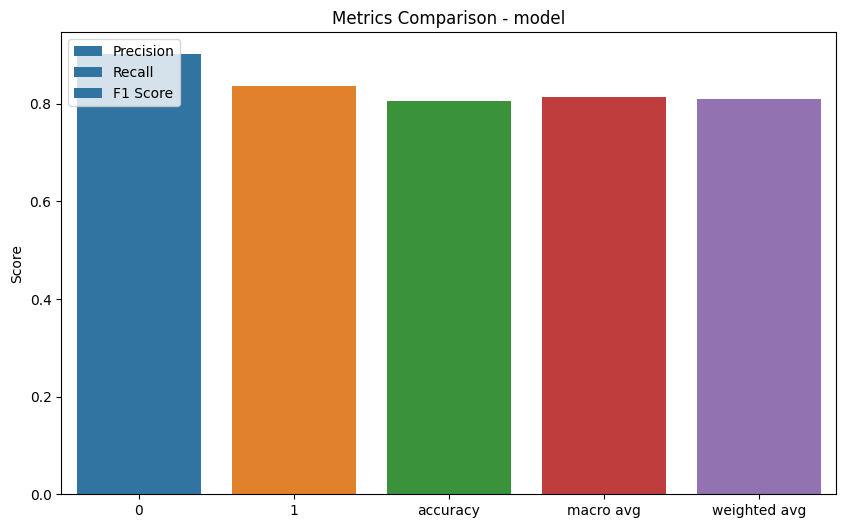

In [10]:
# Visualize metrics for our model 
def visualize_metrics(y_true, y_pred, title):
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Heatmap for Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification Report
    print(f'Classification Report - {title}:')
    print(classification_report(y_true, y_pred))
    
    # Visualize Precision, Recall, F1 Score
    metrics_df = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics_df.index, y=metrics_df['precision'], label='Precision')
    sns.barplot(x=metrics_df.index, y=metrics_df['recall'], label='Recall')
    sns.barplot(x=metrics_df.index, y=metrics_df['f1-score'], label='F1 Score')
    plt.title(f'Metrics Comparison - {title}')
    plt.ylabel('Score')
    plt.legend()
    plt.show()
    
   # Visualizing the metrics for our model
visualize_metrics(y_val, y_pred_val_ensemble, 'model')

In [11]:
# testing data 
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')  

# Clean and preprocess the text in the test dataset
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Tokenization and removing stop words
test_data['tokenized_text'] = test_data['cleaned_text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

# Use the same TF-IDF vectorizer as you used for training
X_test = tfidf_vectorizer.transform(test_data['cleaned_text']).toarray()

# Make predictions on the test set
y_pred_test = ensemble_model.predict(X_test)

submission_df = pd.DataFrame({
    'id': test_data['id'],  
    'target': y_pred_test
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

